In [1]:
import pandas as pd;
import os;
import matplotlib.pyplot as plt
import seaborn as sns

def get_files_in_directory(path: str):
    """
    Returns a list of files in a directory.
    """
    return os.listdir(path)

def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)

def visualize_line_plot(df: pd.DataFrame, labels: list[str], title: str, ax: plt.Axes):
    """
    Visualizes a line plot.
    """
    for label in labels:
        df.plot(x="Date", y=label, ax=ax, label=label)

    ax.set_title(title)
    ax.legend()

def visualize_area_of_volume(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes a histogram of the volume.
    """
    df.plot(x="Date", y="Volume", ax=ax, kind="area", color="green")
    ax.set_title("Volume")

def visualize_data(df: pd.DataFrame, labels: list[str], title: str):
    """
    Visualizes the data.
    """
    fig, plots = plt.subplots(2, 2, figsize=(16, 9))
    fig.suptitle("Stock price over time", fontsize=16)

    visualize_line_plot(df, labels, title, plots[0, 0])
    visualize_correlation(df, plots[1, 0])
    visualize_area_of_volume(df, plots[0, 1])

    plt.show()

def visualize_correlation(df: pd.DataFrame, ax: plt.Axes):
    """
    Visualizes the correlation between columns.
    """

    df1 = df.iloc[:, 1:]
    correlations = df1.corr(method="spearman")
    sns.heatmap(correlations, cmap="Greens" , annot=True, ax=ax)
    ax.set_title("Correlation between columns")

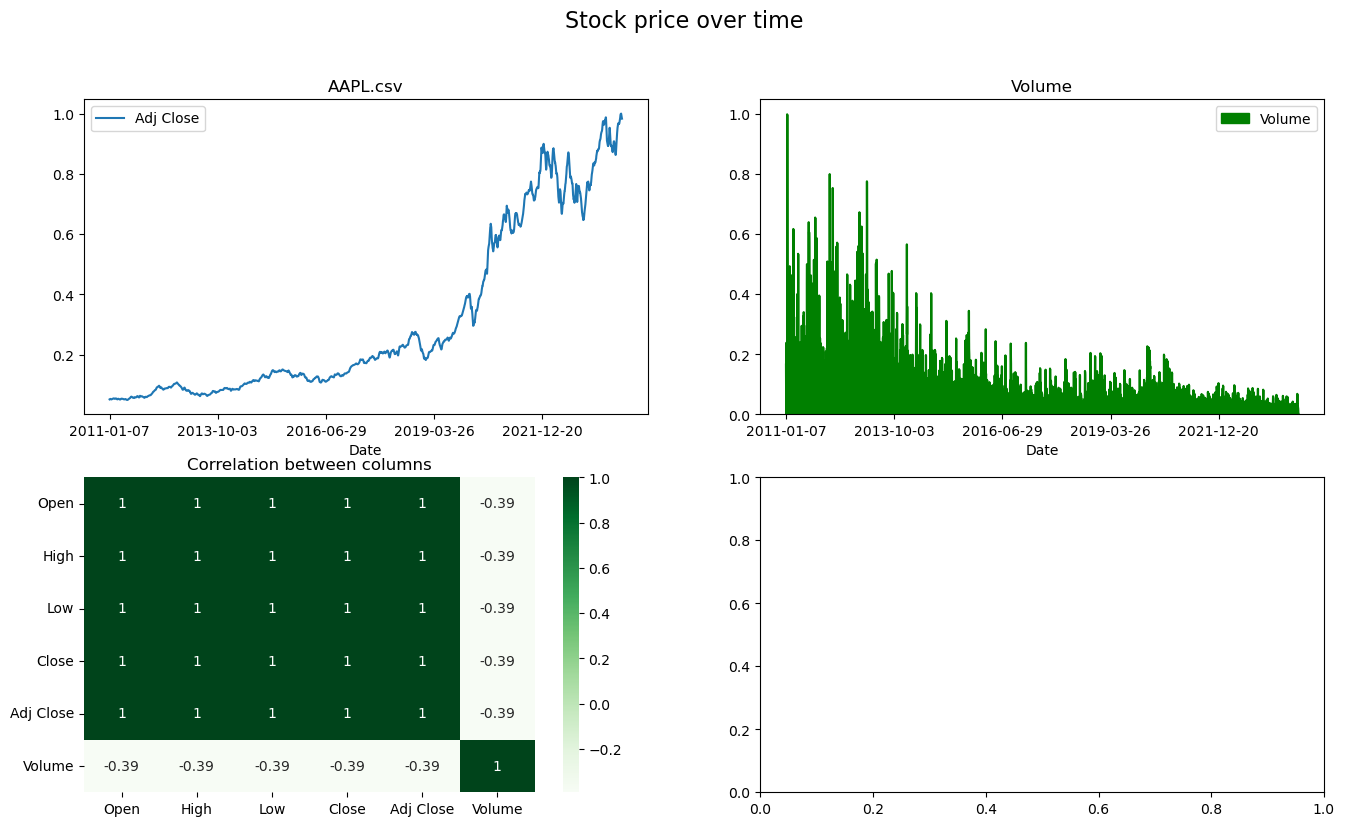

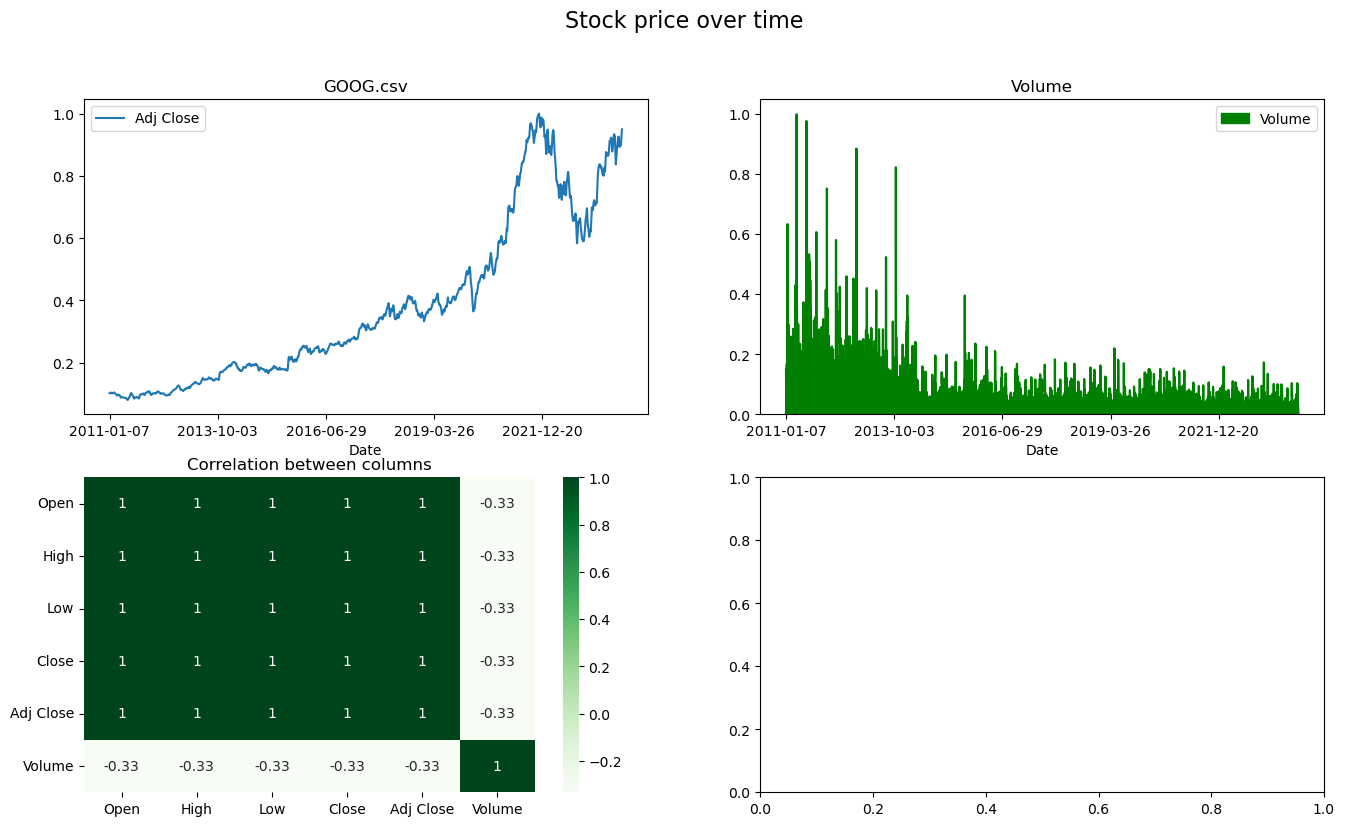

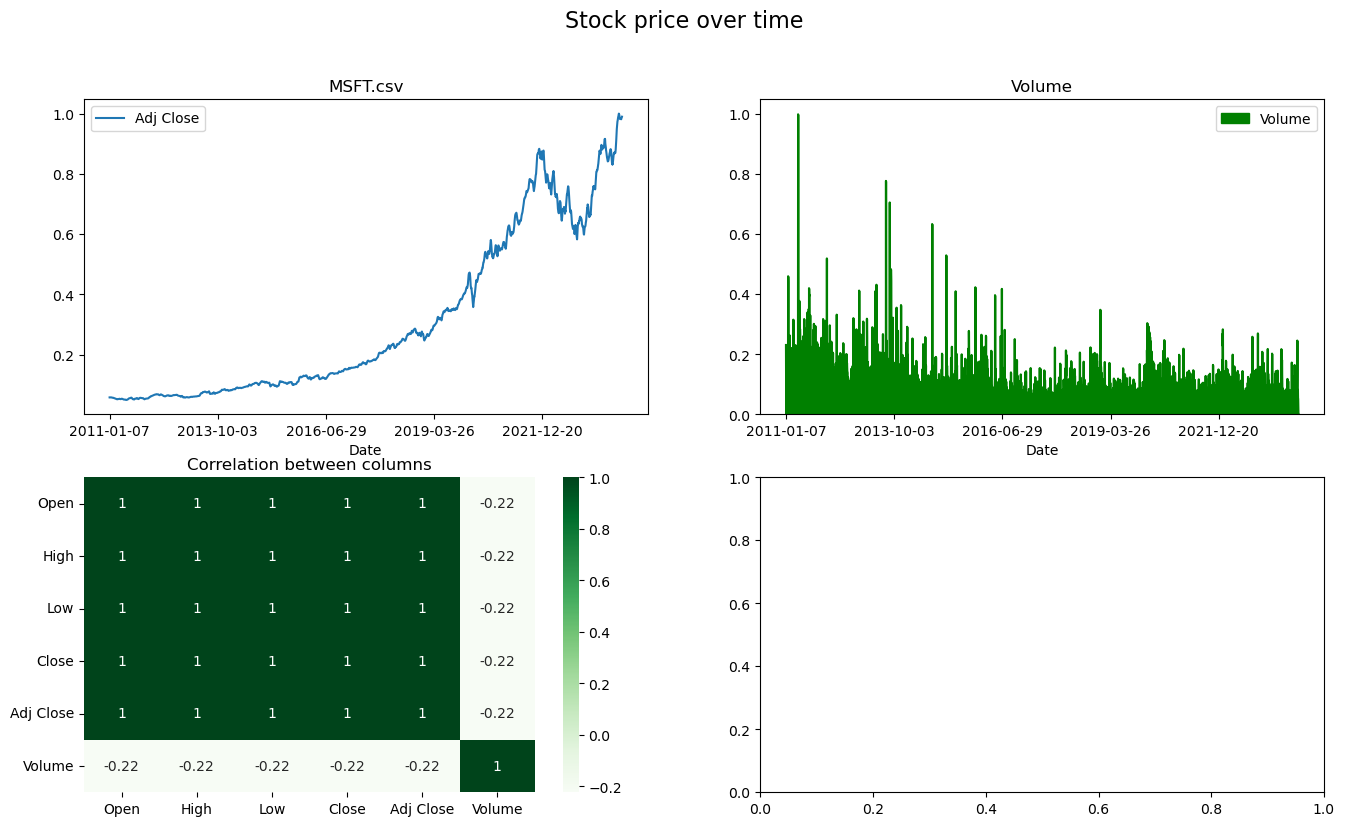

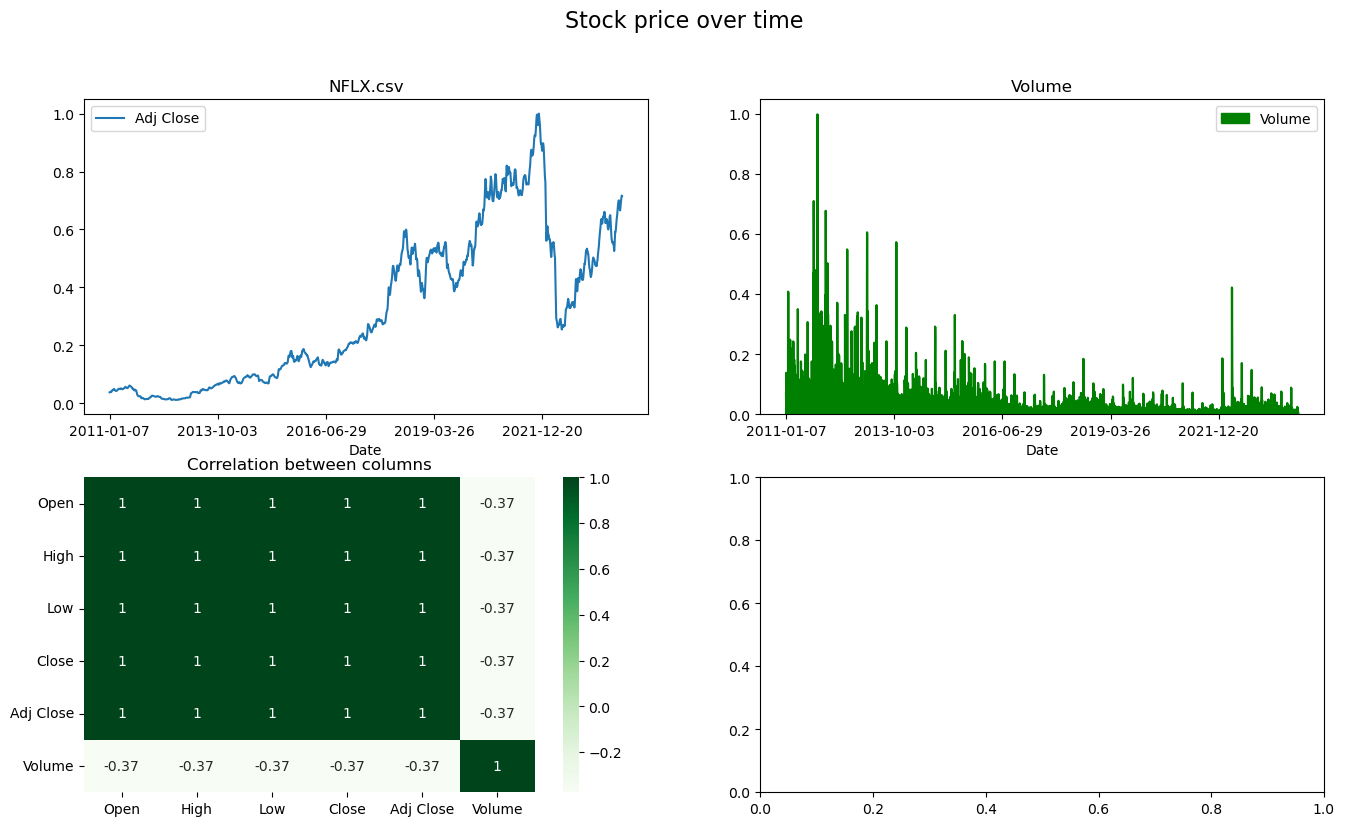

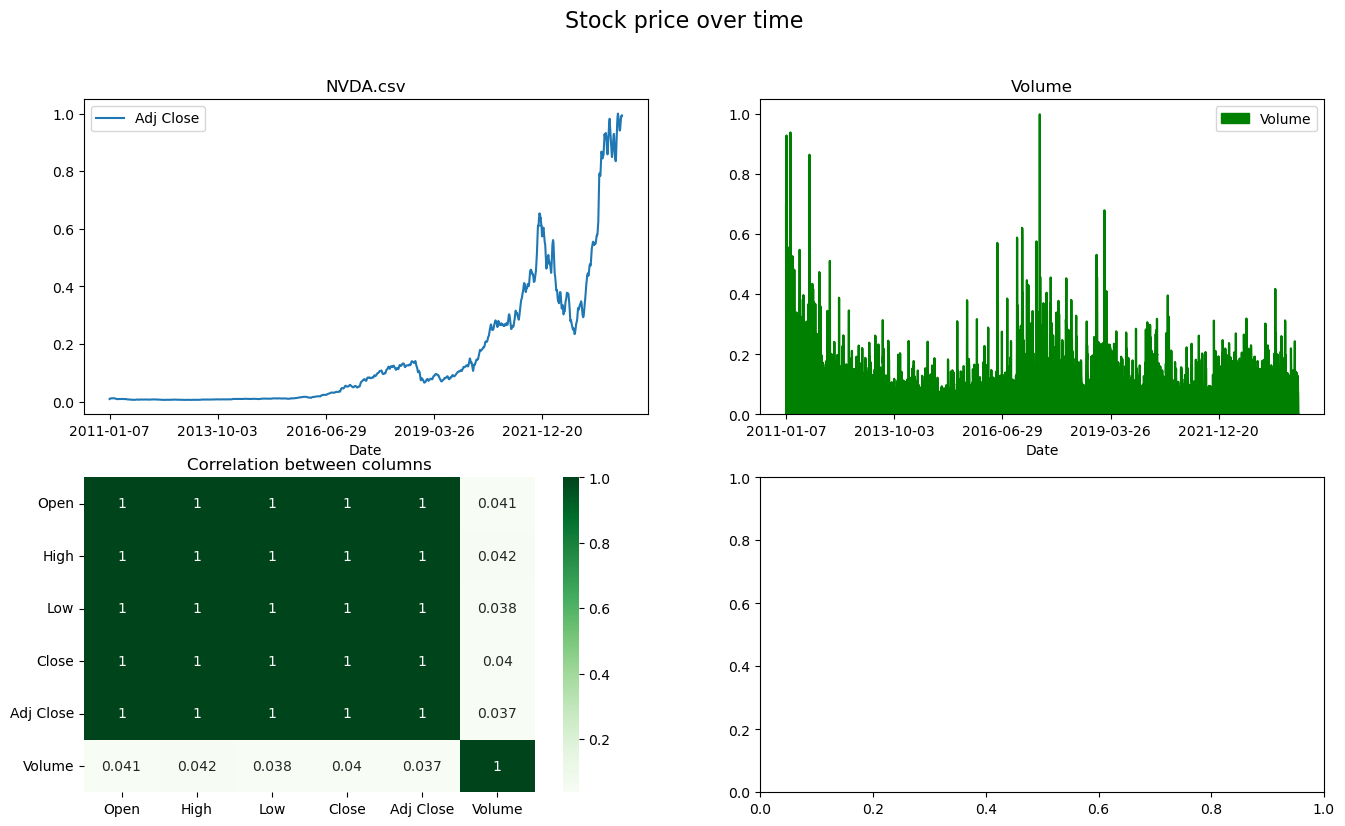

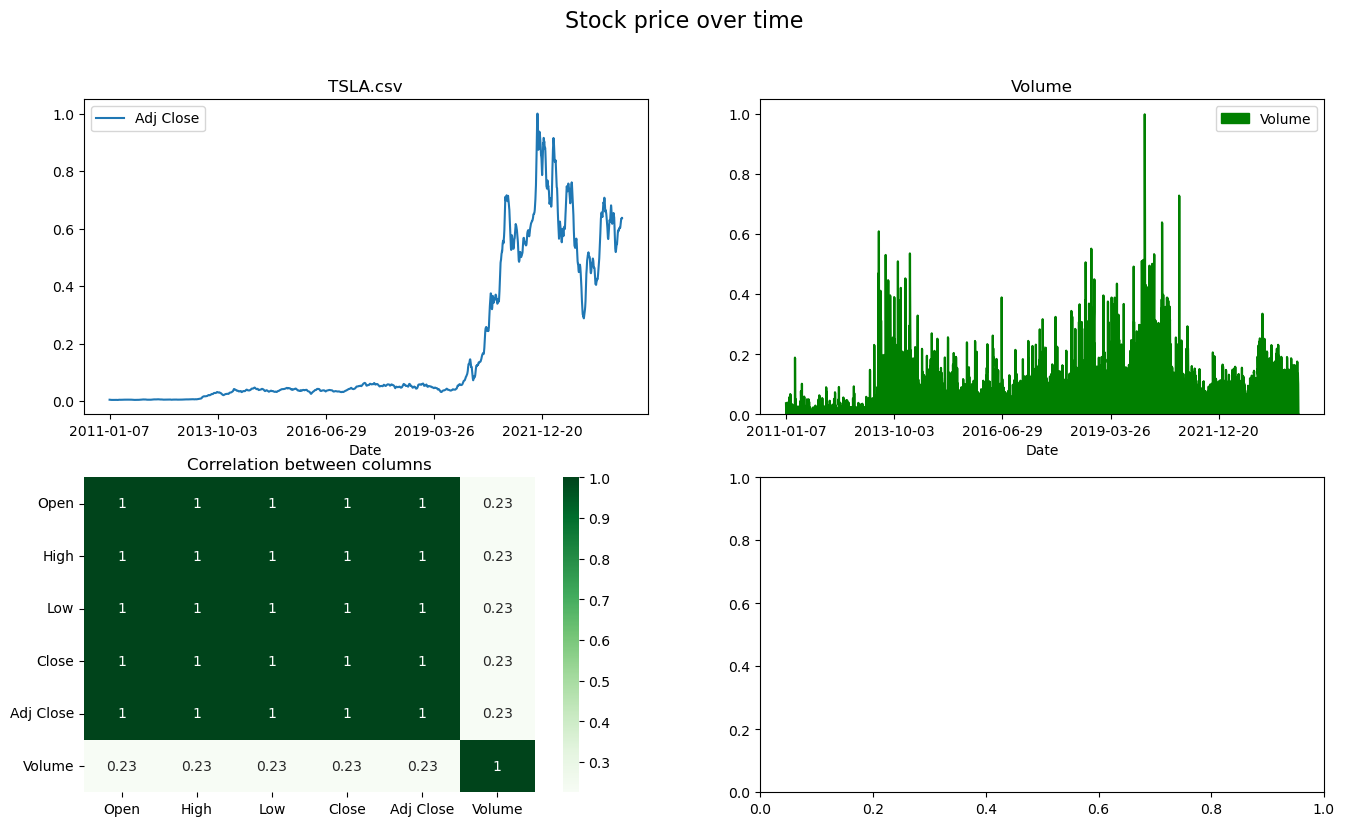

In [3]:
files = get_files_in_directory("processed")
for file in files:
    df = import_data_from_csv("processed/" + file)
    visualize_data(df, ["Adj Close"], file)